### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# evaluation metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, f1_score,
                             precision_recall_fscore_support)


# scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# autoencoder
import tensorflow as tf
from tensorflow import keras

# deep learning
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,Lambda
)
from keras.optimizers import Adam

### LOADING DATASET

In [2]:
credit_card = pd.read_excel("card transactions.xlsx")

### DATA PREPROCESSING 

In [3]:
credit_card.shape

(96753, 10)

In [4]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96753 non-null  int64         
 1   Cardnum            96753 non-null  int64         
 2   Date               96753 non-null  datetime64[ns]
 3   Merchnum           93378 non-null  object        
 4   Merch description  96753 non-null  object        
 5   Merch state        95558 non-null  object        
 6   Merch zip          92097 non-null  float64       
 7   Transtype          96753 non-null  object        
 8   Amount             96753 non-null  float64       
 9   Fraud              96753 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.4+ MB


### EXTRACT DAY AND MONTH FOR FURTHER ANALYSIS

In [5]:
day =pd.to_datetime(credit_card['Date']).dt.dayofweek
month =pd.to_datetime(credit_card['Date']).dt.month
credit_card.insert(1, 'day', day)
credit_card.insert(2, 'month', month)
credit_card = credit_card.drop('Date', axis = 1)

In [6]:
dict_populated = {}
for i in credit_card.columns.to_list():
    dict_populated[i] = credit_card[i].count()/len(credit_card)*100
dict_populated

{'Recnum': 100.0,
 'day': 100.0,
 'month': 100.0,
 'Cardnum': 100.0,
 'Merchnum': 96.51173607019938,
 'Merch description': 100.0,
 'Merch state': 98.76489617892985,
 'Merch zip': 95.1877461163995,
 'Transtype': 100.0,
 'Amount': 100.0,
 'Fraud': 100.0}

### CHECKING FOR NULL VALUES

In [7]:
credit_card.isnull().sum()

Recnum                  0
day                     0
month                   0
Cardnum                 0
Merchnum             3375
Merch description       0
Merch state          1195
Merch zip            4656
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

### DROPPING THE NULL VALUES

In [8]:
credit_card = credit_card.dropna()
credit_card

,Recnum,day,month,Cardnum,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,4,1,5142190439,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,4,1,5142183973,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,4,1,5142131721,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,4,1,5142148452,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,4,1,5142190439,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
...,...,...,...,...,...,...,...,...,...,...,...
96748,96749,4,12,5142276053,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0
96749,96750,4,12,5142225701,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0
96750,96751,4,12,5142226486,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0
96751,96752,4,12,5142244619,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0


### UNIQUE VALUES

In [9]:
dict_unique = {}
for i in credit_card.columns.to_list():
    dict_unique[i]=len(credit_card[i].unique())
dict_unique

{'Recnum': 90198,
 'day': 7,
 'month': 12,
 'Cardnum': 1622,
 'Merchnum': 12807,
 'Merch description': 12184,
 'Merch state': 51,
 'Merch zip': 4452,
 'Transtype': 1,
 'Amount': 33878,
 'Fraud': 2}

### CHECKING FOR DUPLICATES

In [10]:
credit_card.duplicated().sum()

0

### STATISTICS SUMMARY

In [11]:
credit_card.describe()

,Recnum,day,month,Cardnum,Merch zip,Amount,Fraud
count,90198.000000,90198.000000,90198.000000,9.019800e+04,90198.000000,90198.000000,90198.000000
mean,48355.064835,2.571576,6.320063,5.142202e+09,44581.840872,397.266831,0.011331
std,27697.328106,2.109709,3.210985,5.589836e+04,28269.803688,816.286539,0.105841
min,1.000000,0.000000,1.000000,5.142110e+09,1.000000,0.010000,0.000000
25%,24550.250000,1.000000,4.000000,5.142151e+09,20854.000000,33.780000,0.000000
50%,48459.500000,2.000000,6.000000,5.142196e+09,38118.000000,139.000000,0.000000
75%,72101.750000,5.000000,9.000000,5.142245e+09,63103.000000,429.977500,0.000000
max,96753.000000,6.000000,12.000000,5.142847e+09,99999.000000,30372.460000,1.000000


### EXPLORING THE DATASET

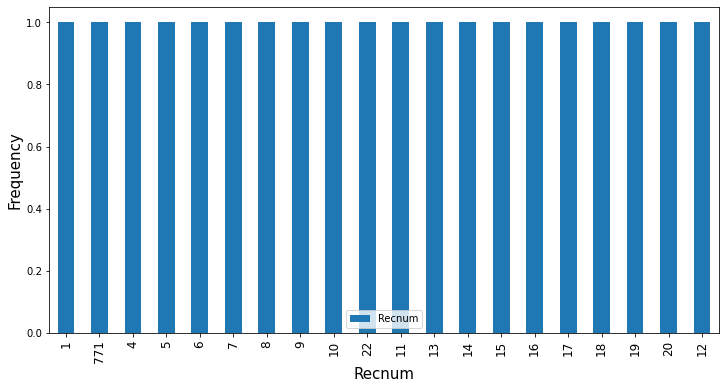

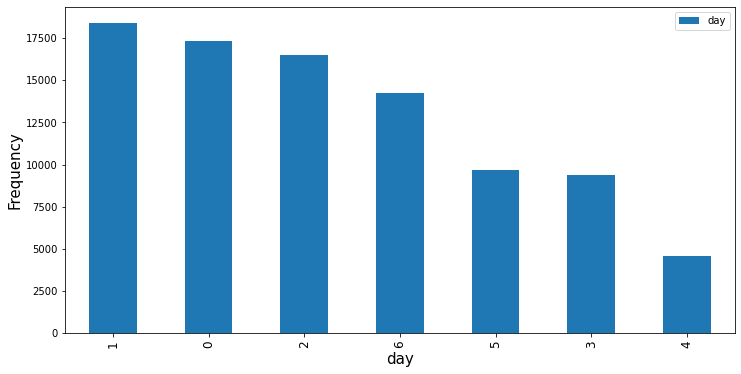

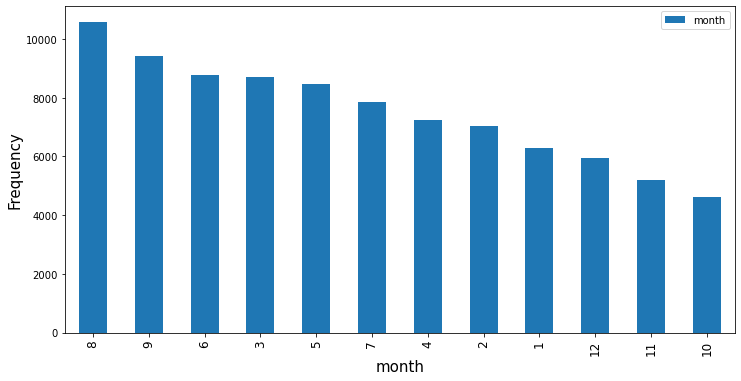

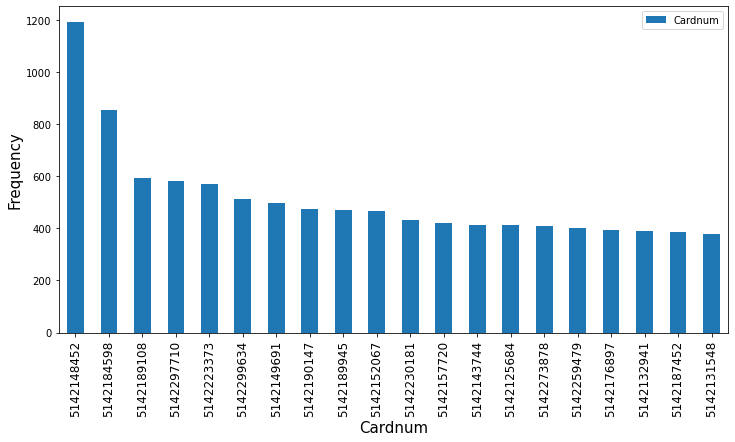

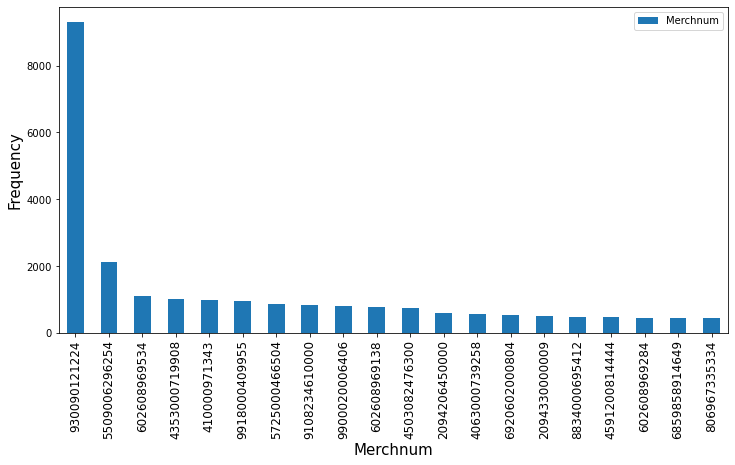

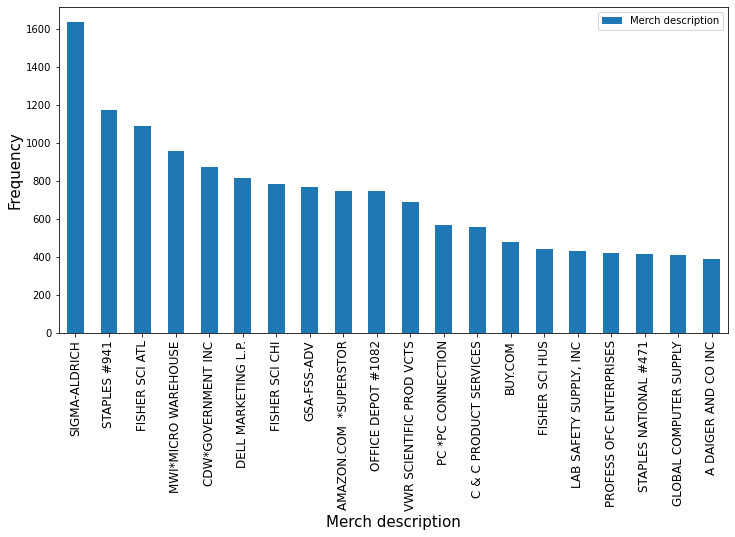

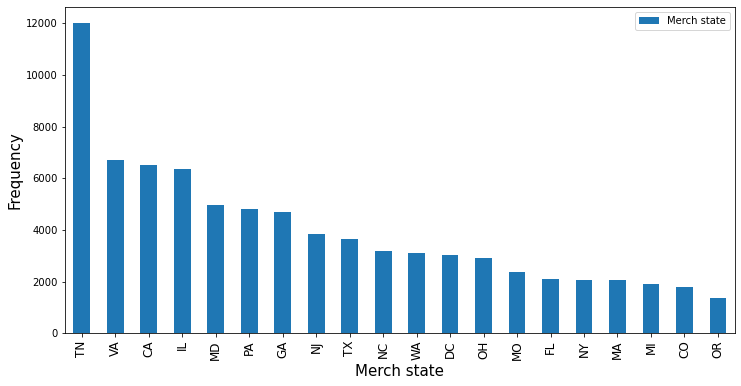

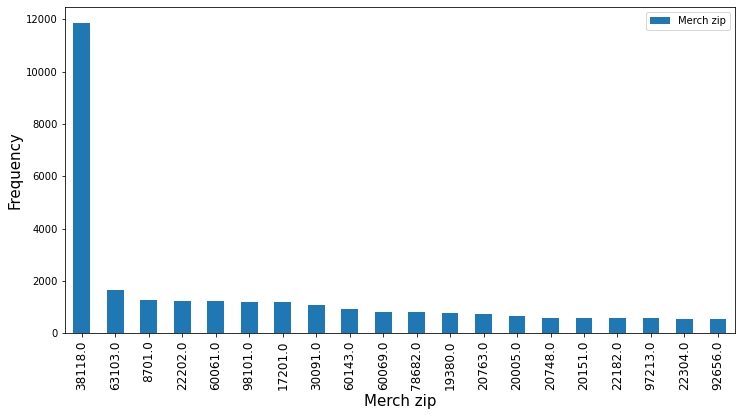

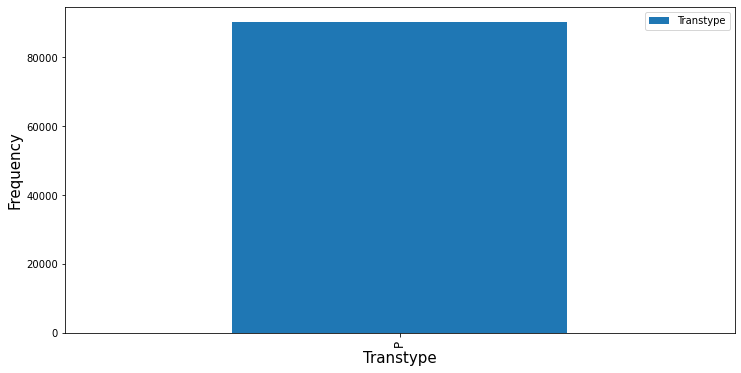

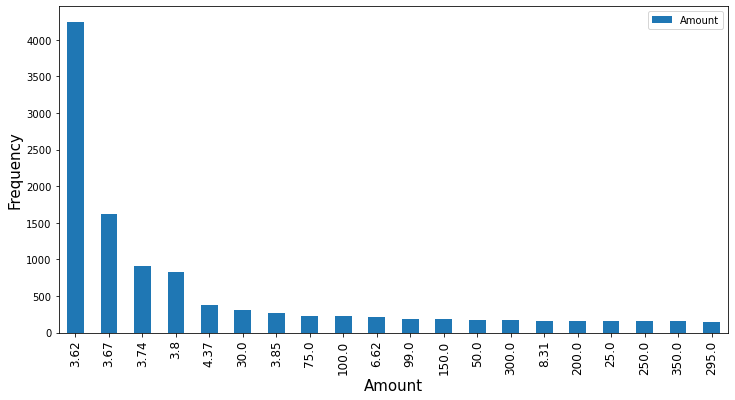

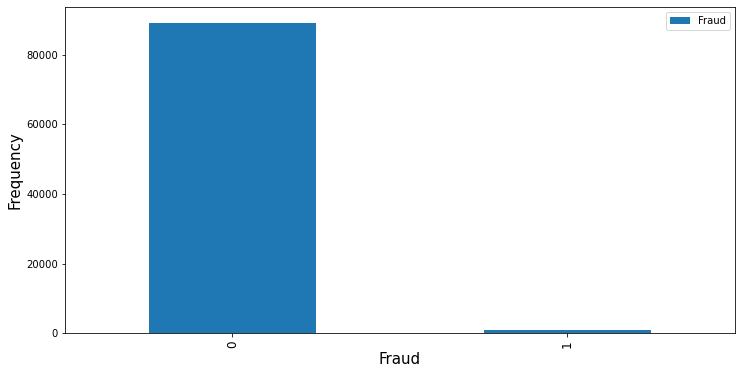

In [12]:
categoricalVar = credit_card.columns.tolist()
for col in categoricalVar:
    df = pd.DataFrame(credit_card[col].value_counts().sort_values(ascending=False).head(20))
    df.plot(kind='bar',figsize=(12,6))
    plt.xlabel(col,fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=12)

C:\Users\Home\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

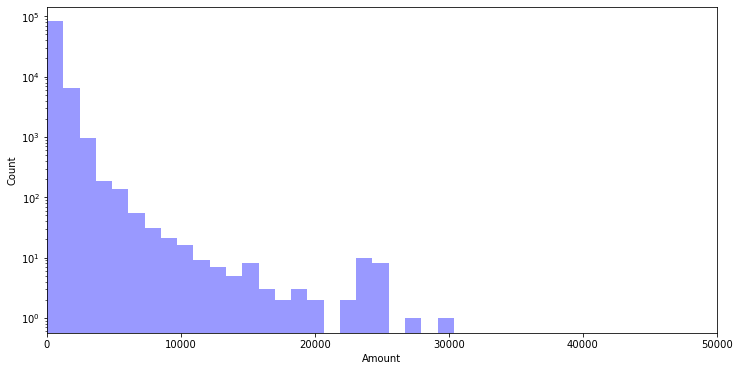

In [13]:
plt.rcParams["figure.figsize"] = [12,6]
xhigh = 50000
plt.xlim(0,xhigh)
temp = credit_card[credit_card['Amount'] <= xhigh]
sns.set_palette("deep")
plot=sns.distplot(temp['Amount'],bins=25, kde=False, color='blue')
plot.set_yscale('log')
plt.ylabel('Count')

Text(0.5, 0, 'Amount')

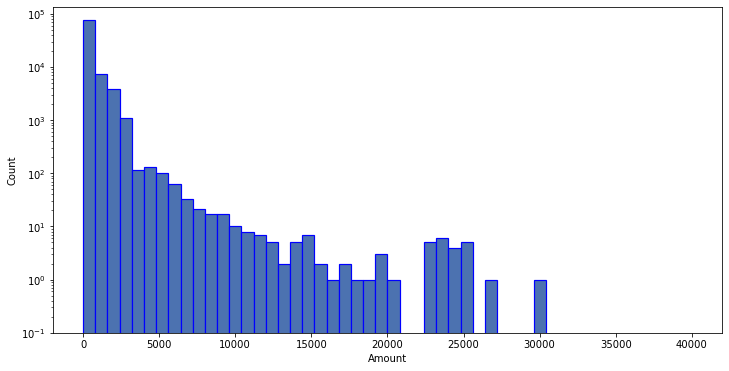

In [14]:
plt.hist(credit_card['Amount'],bins=50,range=[0,40000],edgecolor='blue',linewidth=1.2)
plt.yscale('log')
plt.ylim(bottom = .1)
plt.ylabel('Count')
plt.xlabel('Amount')

### CORRELATION ANALYSIS

In [15]:
credit_card_corr = credit_card.corr()['Fraud'].abs().sort_values(ascending=False)
credit_card_corr

Fraud        1.000000
Amount       0.217197
Cardnum      0.042390
month        0.037741
Recnum       0.037017
Merch zip    0.032984
day          0.014640
Name: Fraud, dtype: float64

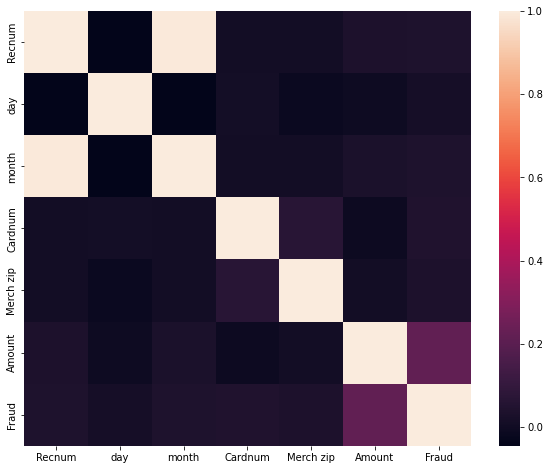

In [16]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(credit_card.corr())
plt.show()

The correlation plot shows no presence of multi collinearity amongst the features (PCA components). All of these features does not show high correlation with the target class

### DISTRIBUTION OF TARGET CLASS

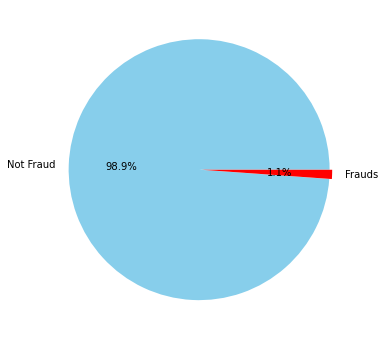

In [17]:
plt.figure(figsize=(10,6))
labels = ['Not Fraud' , 'Frauds']
explode = [.01,.01]
color = ['skyblue' , 'Red']
sizes = credit_card.Fraud.value_counts().values

plt.pie(sizes,explode,labels,autopct="%1.1f%%", colors = color)
plt.show()

The pie chart shows highly imbalanced dataset. 

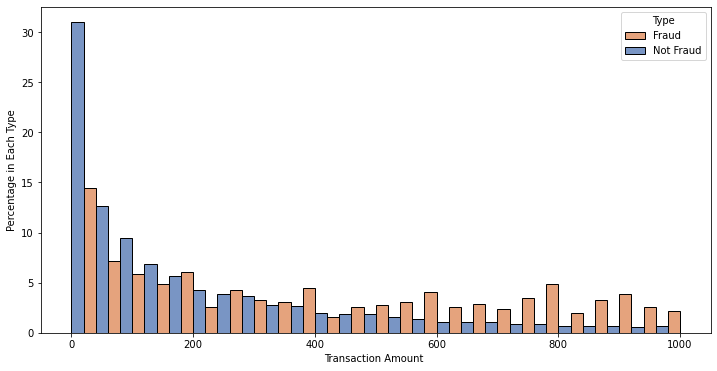

In [18]:
ax=sns.histplot(x='Amount',data=credit_card[credit_card.Amount<=1000],
                hue='Fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount ')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### STATE VS FRAUD : let's also explore which geographies are more prone to fraud. 

Text(0.5, 1.0, 'The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

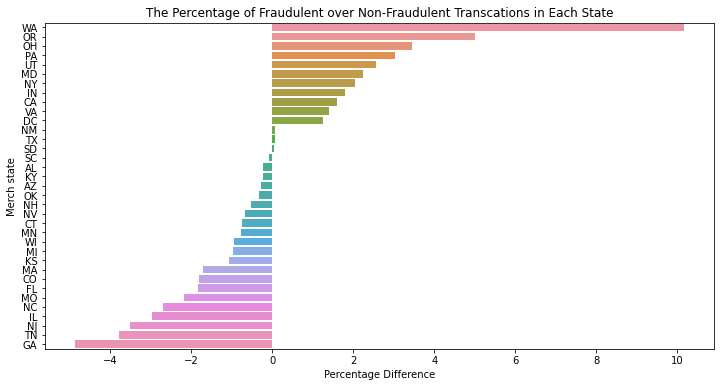

In [19]:
a=credit_card['Merch state'][credit_card.Fraud==0].value_counts(normalize=True)
a=a.to_frame()
a=a.reset_index()
a.columns = ['Merch state', 'Per']

b=credit_card['Merch state'][credit_card.Fraud==1].value_counts(normalize=True)
b=b.to_frame()
b=b.reset_index()
b.columns = ['Merch state', 'Per']

merged=a.merge(b,on='Merch state')
merged['diff']=merged['Per_y']-merged['Per_x']
merged['diff']=merged['diff']*100
merged=merged.sort_values('diff',ascending=False)

ax1=sns.barplot(data=merged, x='diff',y='Merch state')
ax1.set_xlabel('Percentage Difference')
ax1.set_ylabel('Merch state')
plt.title('The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

### Monthly trends

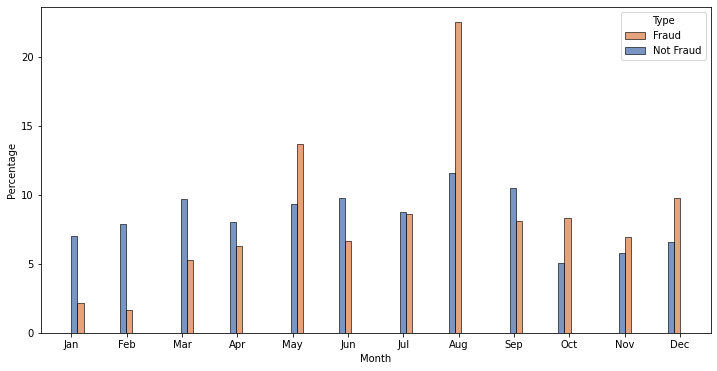

In [20]:
#month vs fraud
ax=sns.histplot(data=credit_card, x="month", hue="Fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Month')
plt.xticks(np.arange(1,13,1))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### Daily trend

C:\Users\Home\AppData\Local\Temp\ipykernel_28744\3150562307.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])


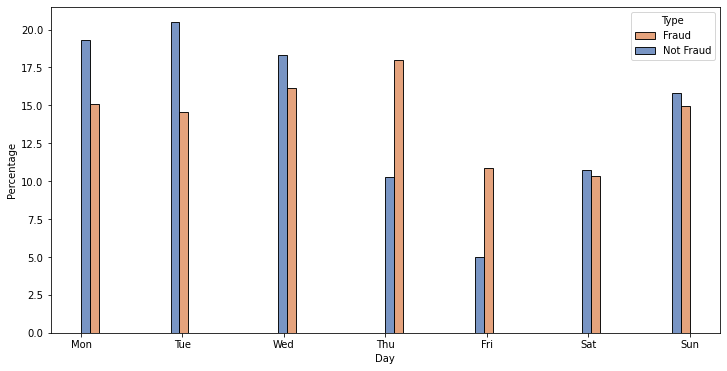

In [21]:
ax=sns.histplot(data = credit_card, x="day", hue="Fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax.set_ylabel('Percentage')
ax.set_xlabel('Day')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### EXTRACTING THE FEATURES AND LABELS FROM THE DATAFRAME 

In [22]:
X = credit_card.drop(labels='Fraud', axis=1) # Features
y = credit_card['Fraud']  # Target Variable

print("X Shape: ", X.shape)
print("y Shape: ", y.shape)
print("========================================")
print("Target Class Value Count: ")
print("Normal Class: ", (y == 0).sum())
print("Fraud Class: ", (y == 1).sum())

fraud = credit_card[credit_card["Fraud"] == 1]
non_fraud = credit_card[credit_card["Fraud"] == 0]

outlier_fraction = len(fraud) / float(len(non_fraud))
print("========================================")
print("Fraud Fraction: ", outlier_fraction)

X Shape:  (90198, 10)
y Shape:  (90198,)
Target Class Value Count: 
Normal Class:  89176
Fraud Class:  1022
Fraud Fraction:  0.011460482641069346


### ENCODING INDEPENDENT VARIABLE

In [23]:
le = LabelEncoder()
X["Merchnum"] = le.fit_transform(credit_card['Merchnum'])
X["Merch description"] = le.fit_transform(credit_card['Merch description'])
X["Merch state"] = le.fit_transform(credit_card['Merch state'])
X["Transtype"] = le.fit_transform(credit_card['Transtype'])

### ENCODING DEPENDENT VARIABLE

In [24]:
#encoding the dependent variable
#labelencoder_y = LabelEncoder()  
#y = labelencoder_y.fit_transform(y)

### FEATURE SCALING THE DATASET 

In [25]:
#standardize the independent variables of the dataset 
X = StandardScaler().fit_transform(X)

### SPLITTING THE DATASET

In [26]:
#splitting the data to 80-20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Check the number of records
from collections import Counter
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 72158
The number of records in the test dataset is 18040
The training dataset has 71331 records for the majority class and 827 records for the minority class.


### RANDOM OVERSAMPLING

In [27]:
# Oversampling only on train
from collections import Counter 
from imblearn.over_sampling import RandomOverSampler

print('Original dataset shape %s' % Counter(y_train))
random_state = 42

ros = RandomOverSampler(random_state=random_state)
X_res, y_res = ros.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

X_train = X_res
y_train = y_res

print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)


# Keep only the normal data for the training dataset
X_train_normal = X_train[np.where(y_train == 0)]
X_train_fraud = X_train[np.where(y_train == 1)]

Original dataset shape Counter({0: 71331, 1: 827})
Resampled dataset shape Counter({0: 71331, 1: 71331})
X_train -  (142662, 10)
y_train -  (142662,)
X_test -  (18040, 10)
y_test -  (18040,)


### GENERAL  AUTOENCODER

The Autoencoder model for anomaly detection has some steps as follows: 

Step 1 is the encoder step. The essential information is extracted by a neural network model in this step.

Step 2 is the decoder step. In this step, the model reconstructs the data using the extracted information.

Step 3: Iterate step 1 and step 2 to adjust the model to minimize the difference between input and reconstructed output, until we get good reconstruction results for the training dataset.

Step 4: Make predictions on a dataset that includes outliers.

Step 5: Set up a threshold for outliers/anomalies by comparing the differences between the autoencoder model reconstruction value and the actual value.

Step 6: Identify the data points with the difference higher than the threshold to be outliers or anomalies.

#### INPUT LAYER

In [28]:
# 'tanh' is used for the activation function of the encoded network 
# because it has big learning steps and results in strong or higher gradients

#relu is used on the bottle neck (latent low representation) 
#because model performance is better when trained with relu

#sigmoid is used for binary classification and since we have 
#fraud and non fraudclass then it is good for this problem

#In the input layer, we specified the shape of the dataset. 

input_layer = Input(shape=(X_train.shape[1],))

#### BUILDING THE ENCODER NETWORK

In [29]:
#The encoder consists of 4 layers with 512, 256, 128, 64 neurons, respectively. 
#Note that the encoder requires the number of neurons to decrease with the layers. 
#The last layer in the encoder is the size of the encoded representation, and it is also called the bottleneck.


encoded = Dense(512, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(256, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(128, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(64, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(6, activation="relu")(encoded)

#### BUILDING THE DECODER NETWORK

In [30]:
# The decoder consists of 4 layers with 64, 128, 256 and 512 neurons, respectively. 
#Opposite from the encoder, the decoder requires the number of neurons to increase with the layers. 
#The output layer in the decoder has the same size as the input layer.


decoded = Dense(64, activation="tanh")(encoded)
decoded = Dense(128, activation="tanh")(decoded)
decoded = Dense(256, activation="tanh")(decoded)
decoded = Dense(512, activation="tanh")(decoded)

#### OUTPUT LAYER

In [31]:
output_layer = Dense(X_train.shape[1], activation="sigmoid")(decoded)

#### MODEL CREATION

In [32]:
#After defining the input, encoder, and decoder layers, we create the autoencoder model to combine the layers.
autoencoder = Model(input_layer, output_layer)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 512)               5632      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 64)                448   

In [33]:
# compiling the auto encoder model  with the optimizer of adam and the loss of mse (Mean squared Error).
autoencoder.compile(optimizer="adam", loss="mse")

#When fitting the autoencoder model, we can see that the input and output datasets are the same,
#which is the dataset that contains only the normal data points.

#The epochs of 50 and batch_size of 32 mean the model uses 32 datapoints to update the weights in each iteration, 
#and the model will go through the whole training dataset 50 times.

#shuffle=True will shuffle the dataset before each epoch.

# training the auto encoder model on non fraud data 
history = autoencoder.fit(X_train_normal,X_train_normal,batch_size=128,epochs=20,shuffle=True,validation_split=0.20,)

Epoch 1/20
446/446 [==============================] - 11s 17ms/step - loss: 0.5627 - val_loss: 0.5030
Epoch 2/20
446/446 [==============================] - 7s 16ms/step - loss: 0.5144 - val_loss: 0.4956
Epoch 3/20
446/446 [==============================] - 7s 15ms/step - loss: 0.5108 - val_loss: 0.4923
Epoch 4/20
446/446 [==============================] - 7s 15ms/step - loss: 0.5078 - val_loss: 0.4917
Epoch 5/20
446/446 [==============================] - 7s 16ms/step - loss: 0.5063 - val_loss: 0.4900
Epoch 6/20
446/446 [==============================] - 8s 18ms/step - loss: 0.5052 - val_loss: 0.4898
Epoch 7/20
446/446 [==============================] - 7s 16ms/step - loss: 0.5050 - val_loss: 0.4884
Epoch 8/20
446/446 [==============================] - 6s 15ms/step - loss: 0.5044 - val_loss: 0.4872
Epoch 9/20
446/446 [==============================] - 7s 15ms/step - loss: 0.5028 - val_loss: 0.4864
Epoch 10/20
446/446 [==============================] - 7s 16ms/step - loss: 0.5029 - val_l

Text(0.5, 1.0, 'Loss Curves')

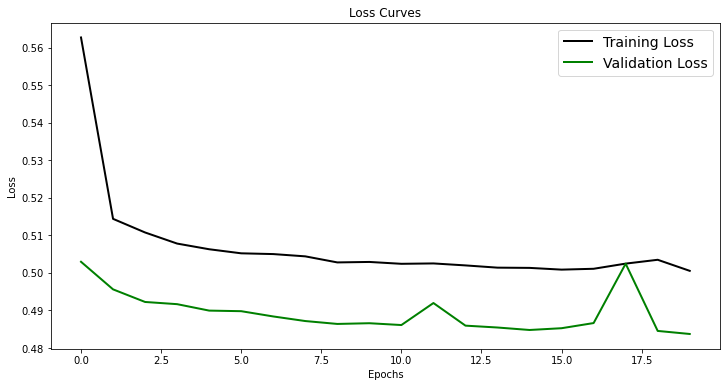

In [34]:
# Loss curve

plt.plot(history.history["loss"], "black", linewidth=2.0)
plt.plot(history.history["val_loss"], "green", linewidth=2.0)
plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)

This chart visualizes the training and validation loss changes during the model fitting. The x-axis is the number of epochs, and the y axis is the loss. We can see that both training and validation losses decrease with the increase of epochs.

In [35]:
# creating the sequential model and adding the trainined weights till the fifth layer
#(till where the latent representation exists)

latent_model = Sequential()
latent_model.add(autoencoder.layers[0])
latent_model.add(autoencoder.layers[1])
latent_model.add(autoencoder.layers[2])
latent_model.add(autoencoder.layers[3])
latent_model.add(autoencoder.layers[4])

In [36]:
# generating the hidden representation of the 2 classes

normal_datapoints = latent_model.predict(X_train_normal)
fraud_datapoints = latent_model.predict(X_train_fraud)

# creating a dataframe of latent representation of the data

encoded_X = np.append(normal_datapoints, fraud_datapoints, axis=0)

y_normal = np.zeros(normal_datapoints.shape[0])

y_fraud = np.ones(fraud_datapoints.shape[0])
encoded_y = np.append(y_normal, y_fraud, axis=0)

2230/2230 [==============================] - 10s 5ms/step


In [37]:
def dimensionality_plot(X, y):

    #     sns.set(style='whitegrid', palette='muted')

    # Initializing TSNE object with 2 principal components
    tsne = TSNE(n_components=2, random_state=42)

    # Fitting the data
    X_trans = tsne.fit_transform(X)

    plt.figure(figsize=(10, 6))

    plt.scatter(
        X_trans[np.where(y == 0), 0],
        X_trans[np.where(y == 0), 1],
        marker="o",
        color="b",
        linewidth=1,
        alpha=0.8,
        label="Normal",
    )

    plt.scatter(
        X_trans[np.where(y == 1), 0],
        X_trans[np.where(y == 1), 1],
        marker="o",
        color="r",
        linewidth=1,
        alpha=0.8,
        label="Fraud",
    )

    plt.legend(loc="best")

    plt.show()


C:\Users\Home\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Home\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


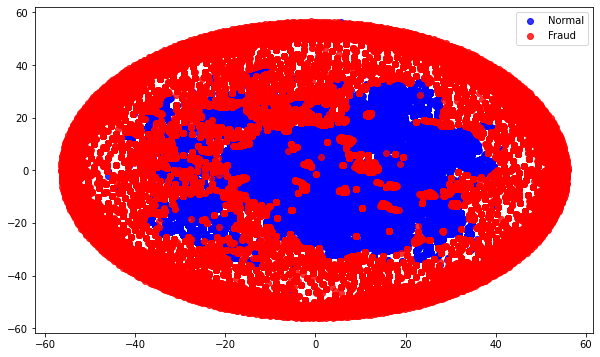

In [38]:
# plotting the TSNE function to visualize the latent data
from sklearn.manifold import TSNE
dimensionality_plot(encoded_X, encoded_y)

#### MODEL EVALUATION

In [39]:
#we have an autoencoder model, let's use it to predict the outliers.
#Firstly, we use .predict to get the reconstruction value for the testing data 
#set containing the usual data points and the outliers.


# Predict anomalies/outliers in the training dataset
prediction = autoencoder.predict(X_test)
prediction.shape

564/564 [==============================] - 2s 3ms/step


(18040, 10)

In [40]:
#mse here is basically the reconstruction error, 
#if the model has learned the normal datapoints well,
#then this error should be less on normal points, and high on fraud points.

mse = np.mean(np.power(X_test - prediction, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'Fraud':y_test})

In [41]:
error_df.groupby(['Fraud']).describe()

reconstruction_error                                                    \
                     count      mean       std       min       25%       50%   
Fraud                                                                          
0                  17845.0  0.503894  1.498209  0.009937  0.259109  0.423001   
1                    195.0  2.533292  8.782912  0.020034  0.252940  0.470724   

                            
            75%        max  
Fraud                       
0      0.631423  99.966453  
1      1.147788  83.688043

C:\Users\Home\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Home\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


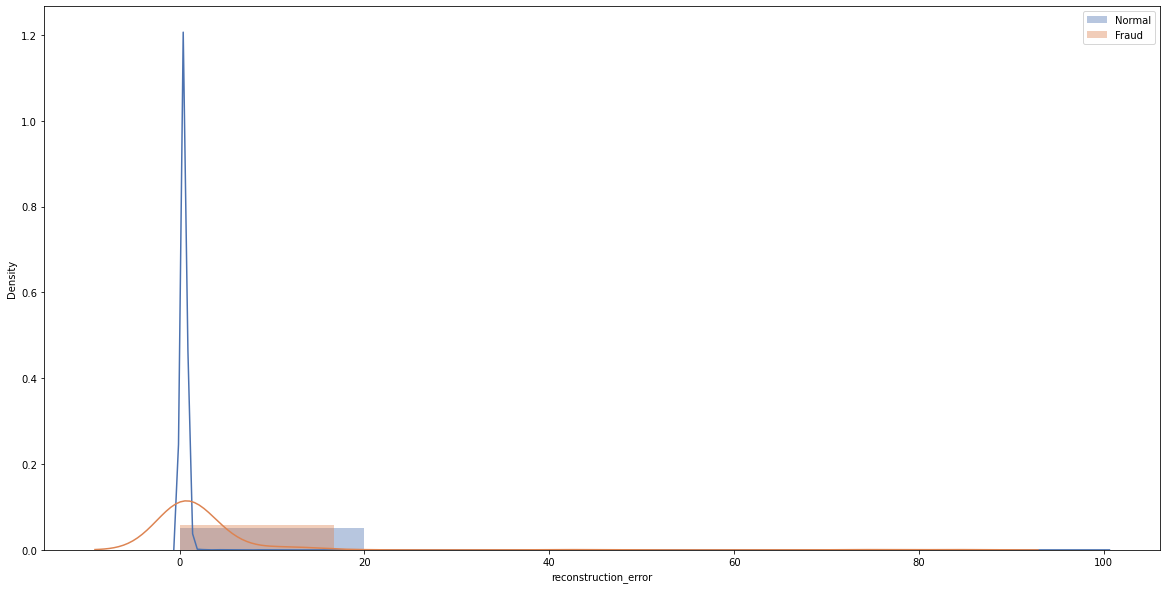

In [42]:
plt.figure(figsize = (20,10))
sns.distplot(error_df[error_df['Fraud']==0]['reconstruction_error'], bins = 5, label = 'Normal')
sns.distplot(error_df[error_df['Fraud']==1]['reconstruction_error'], bins=5, label = 'Fraud')
plt.legend()
plt.show()

In [43]:
threshold = 1.8

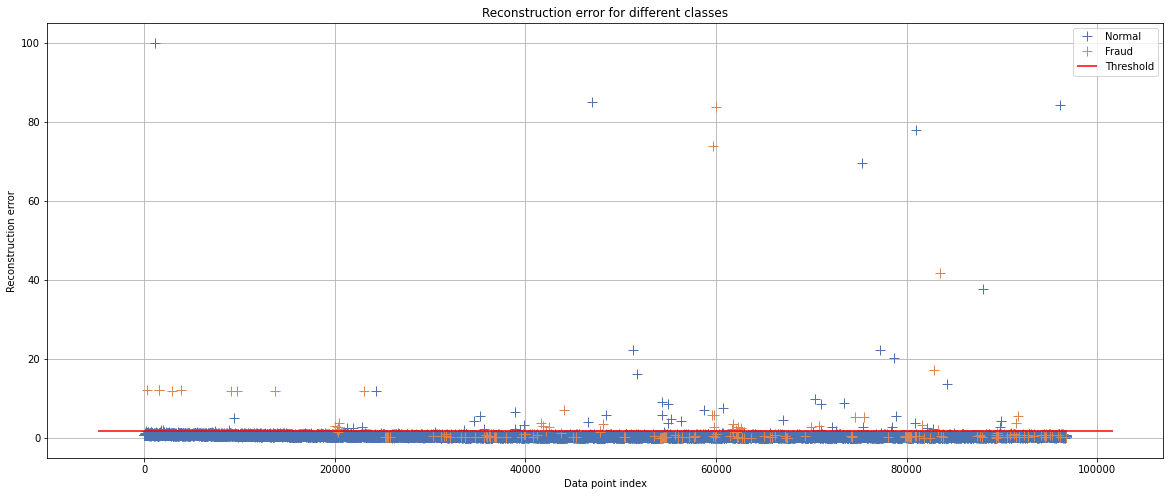

In [44]:
groups = error_df.groupby('Fraud')
fig, ax = plt.subplots(figsize = (20,8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='+', ms=10, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.grid()
plt.show()

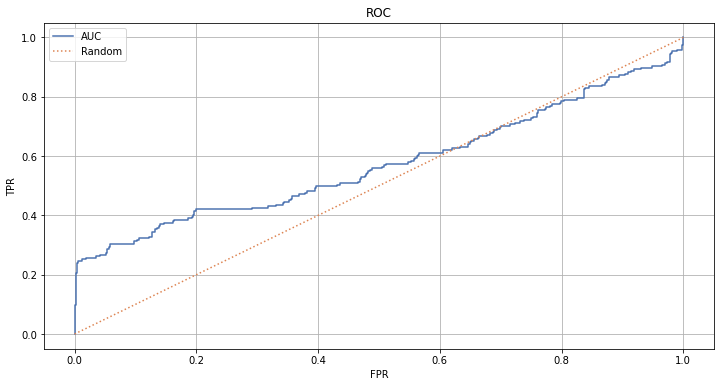

In [45]:
fpr, tpr, thres = roc_curve(error_df.Fraud, error_df.reconstruction_error)
plt.plot(fpr, tpr, label = 'AUC') 
plt.plot([0,1], [0,1], ':', label = 'Random') 
plt.legend() 
plt.grid() 
plt.ylabel("TPR") 
plt.xlabel("FPR") 
plt.title('ROC') 
plt.show()

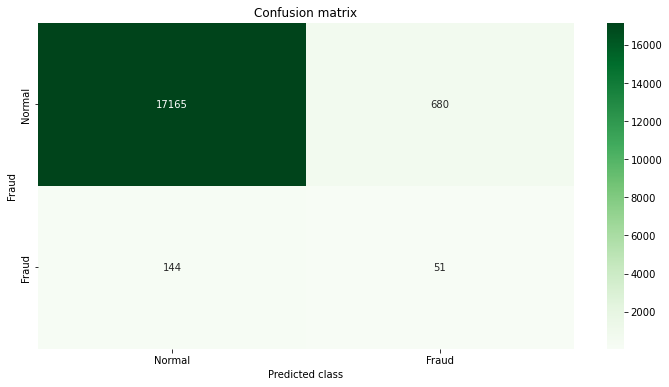

In [46]:
LABELS = ['Normal', 'Fraud']
threshold = 1
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.Fraud, y_pred)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='Greens');
plt.title("Confusion matrix")
plt.ylabel('Fraud')
plt.xlabel('Predicted class')
plt.show()

In [47]:
## Chosen metric is AUC ROC
print("Area under ROC : ", roc_auc_score(error_df.Fraud,y_pred ))

Area under ROC :  0.6117162747591439


In [48]:
# Get the mean squared error between actual and reconstruction/prediction
prediction_loss = tf.keras.losses.mse(prediction, X_test)

In [49]:
# a threshold is set to identify the outliers. 
#This threshold can be based on percentile, standard deviation, or other methods. 
#We use 98% loss as the threshold to identify 2% of the data as outliers in this example.


# Check the prediction loss threshold for 75% of outliers
loss_threshold = np.percentile(prediction_loss, 75)
print(f'The prediction loss threshold for 75% percentile of outliers is {loss_threshold:.2f}')

The prediction loss threshold for 75% percentile of outliers is 0.63


#### VARIATIONAL AUTOENCODER

The encoder similarly learns a function that takes as its input a vector of size.
However, instead of learning how to generate a latent vector that the decoder function can reproduce, a VAE learns to generate two vectors that represent the parameters (mean and variance) of a distribution from which the latent vector is sampled, and which the decoder function can transform back to the original input vector. The VAE’s learning task is to learn a function that will generate parameters of distributions from which a latent vector that a decoder can easily reproduce can be sampled.

VAE uses a loss function that consists of 2 components: 
(1) A reconstruction loss component — which forces the encoder to generate latent features that minimize the reconstruction loss

(2) A KL loss component — which forces the distribution generated by the encoder to be similar to the prior probability of the input vector, which is assumed to be normal, and therefore pushes the latent feature space towards normality.

In [50]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [51]:
from keras import backend as K
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]    
    epsilon = K.random_normal(shape=(batch, dim))  # by default, random_normal has mean=0 and std=1.0
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [52]:
# network parameters and learning parameters
original_dim = X_train.shape[1]
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 20

In [53]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [54]:
# sampling 
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) 

In [55]:
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 10)]         0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 512)          5632        ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense_10[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense_10[0][0]']               
                                                                                            

In [56]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [57]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_11 (Dense)            (None, 512)               1536      
                                                                 
 dense_12 (Dense)            (None, 10)                5130      
                                                                 
Total params: 6,666
Trainable params: 6,666
Non-trainable params: 0
_________________________________________________________________


In [58]:
# instantiate VAE model
outputs = decoder(encoder(inputs))
vae = Model(inputs, outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 10)]              0         
                                                                 
 encoder (Functional)        (None, 2)                 7684      
                                                                 
 decoder (Functional)        (None, 10)                6666      
                                                                 
Total params: 14,350
Trainable params: 14,350
Non-trainable params: 0
_________________________________________________________________


In [59]:
## VAE loss
# reconstruction_loss = mse(inputs, outputs)
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
# vae_loss = K.mean(reconstruction_loss)

In [60]:
# vae.compile(optimizer='adam', loss=vae_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 10)]         0           []                               
                                                                                                  
 encoder (Functional)           (None, 2)            7684        ['encoder_input[0][0]']          
                                                                                                  
 decoder (Functional)           (None, 10)           6666        ['encoder[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 512)          5632        ['encoder_input[0][0]']          
                                                                                                

In [61]:
# Learning
# epochs = 50
history = vae.fit(X_train_normal,X_train_normal,batch_size=batch_size,epochs=epochs,shuffle=True,validation_split=0.20,)

Epoch 1/20
446/446 [==============================] - 3s 4ms/step - loss: -89620.2266 - val_loss: -555514.4375
Epoch 2/20
446/446 [==============================] - 2s 4ms/step - loss: -3423318.5000 - val_loss: -8767234.0000
Epoch 3/20
446/446 [==============================] - 2s 4ms/step - loss: -18852746.0000 - val_loss: -32522178.0000
Epoch 4/20
446/446 [==============================] - 2s 4ms/step - loss: -55506592.0000 - val_loss: -85920432.0000
Epoch 5/20
446/446 [==============================] - 2s 4ms/step - loss: -135222160.0000 - val_loss: -199611520.0000
Epoch 6/20
446/446 [==============================] - 2s 4ms/step - loss: -299315872.0000 - val_loss: -425677088.0000
Epoch 7/20
446/446 [==============================] - 2s 4ms/step - loss: -605609024.0000 - val_loss: -825745280.0000
Epoch 8/20
446/446 [==============================] - 2s 4ms/step - loss: -1115773952.0000 - val_loss: -1460689664.0000
Epoch 9/20
446/446 [==============================] - 2s 5ms/step - l

In [62]:
# plot loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Loss Curves')

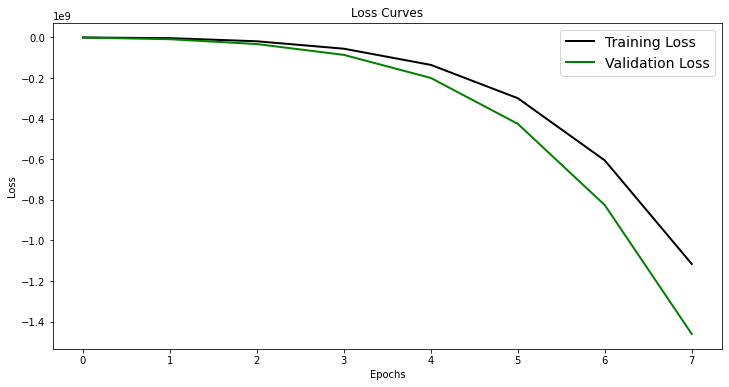

In [63]:
# Loss curve

plt.plot(history.history["loss"], "black", linewidth=2.0)
plt.plot(history.history["val_loss"], "green", linewidth=2.0)
plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)

In [64]:
# creating the sequential model and adding the trainined weights till the fifth layer
#(till where the latent representation exists)

latent_model_Val = Sequential()
latent_model_Val.add(autoencoder.layers[0])


In [65]:
# generating the hidden representation of the 2 classes

normal_datapoints = latent_model_Val.predict(X_train_normal)
fraud_datapoints = latent_model_Val.predict(X_train_fraud)

# creating a dataframe of latent representation of the data

encoded_X = np.append(normal_datapoints, fraud_datapoints, axis=0)

y_normal = np.zeros(normal_datapoints.shape[0])

y_fraud = np.ones(fraud_datapoints.shape[0])
encoded_y = np.append(y_normal, y_fraud, axis=0)

2230/2230 [==============================] - 2s 1ms/step


In [66]:
def dimensionality_plot(X, y):

    #     sns.set(style='whitegrid', palette='muted')

    # Initializing TSNE object with 2 principal components
    tsne = TSNE(n_components=2, random_state=42)

    # Fitting the data
    X_trans = tsne.fit_transform(X)

    plt.figure(figsize=(10, 6))

    plt.scatter(
        X_trans[np.where(y == 0), 0],
        X_trans[np.where(y == 0), 1],
        marker="o",
        color="b",
        linewidth=1,
        alpha=0.8,
        label="Normal",
    )

    plt.scatter(
        X_trans[np.where(y == 1), 0],
        X_trans[np.where(y == 1), 1],
        marker="o",
        color="r",
        linewidth=1,
        alpha=0.8,
        label="Fraud",
    )

    plt.legend(loc="best")

    plt.show()


C:\Users\Home\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Home\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


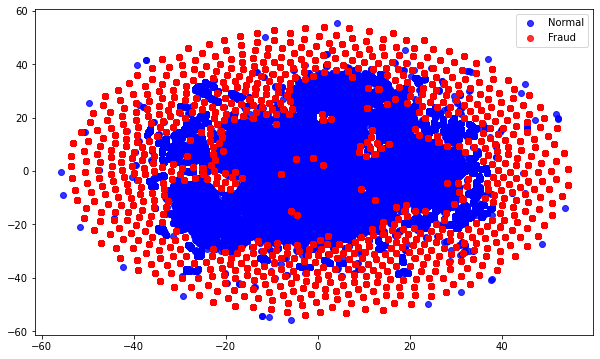

In [67]:
# plotting the TSNE function to visualize the latent data
from sklearn.manifold import TSNE
dimensionality_plot(encoded_X, encoded_y)

In [68]:
# Predict anomalies/outliers in the training dataset
prediction = vae.predict(X_test)
prediction.shape

564/564 [==============================] - 1s 1ms/step


(18040, 10)